In [1]:
#Load packages and functions

import numpy as np
import astropy.io.fits as fits
import glob
import matplotlib.pyplot as plt
import astropy
from astropy import modeling
from scipy.signal import argrelextrema
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit

#Plot stuff
from bokeh.io import output_notebook, show
from bokeh.models import Title, HoverTool, Span
from bokeh.plotting import figure
from bokeh.layouts import gridplot
output_notebook()

#wavelength, flux
def wf(dat): #whichord,dat. Setup:   w,f=wf(#,dat)
    w=np.array([d[0] for d in dat])
    f=np.array([d[1] for d in dat])
    return w,f

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar=''): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')

Loading BokehJS ...

# Normalization Function

In [2]:
#Ultimate norm, capable of K, M, special

#operate on unnorm w,f. Return w, normalized f. For M-stars, dodging molecular bands.
def norm(w,f,spt='K',pltt='y',blaze='n',deg='auto',mskip0='auto',peak=3): #deg='auto' or int
    print('spt options: K,M')
    spts=['K','M']
    degs=[  3,  5]
    if deg=='auto':
        deg=degs[spts.index(spt)]
    #roughly skip the dips
    #dodge broad Ha:
    favg=np.median(f) #Try median, hopefully not ALL peak
    print('favg:',favg)
    Hapeak=[i for i in range(len(w)) if f[i]>favg*peak] #sometimes have to adjust peak
    print(Hapeak)
    if len(Hapeak)>0: #peak present
        Hali=np.min(Hapeak) #left index
        Hari=np.max(Hapeak) #right index
        Hawid=w[Hari]-w[Hali] #wavelength "width" of Ha
        pad=int(Hawid/1.) #pad each side
        HaL,HaR=w[Hali]-pad,w[Hari]+pad #Ha left, right
    else: #peak low or not present, guess
        print('No peak detected.')
        HaL=6555
        HaR=6570
    
    #wavelength regions to skip
    
    if mskip0=='auto':
        if spt=='K':
            mskip0=[6155,6175,6489,6506,HaL,HaR]
#         if spt=='M': #old, delete
#             mskip0=[6148,6190,6210,6250,6350,6400,6420,6444,6447,6454,6463,6466,6493,6504,HaL,HaR,6592,6597,6625,6631,6633,6641,6650,6666,6676,6700]
        if spt=='M':
            mskip0=[6152,6180,6215,6250,6350,6466,6477,6524,HaL,HaR,6592,6597,6625,6631,6633,6641,6650,6666,6676,6700]
    #check for HaL, HaR not in right spot:
    rcount=0
    mskip=[m for m in mskip0] #duplicate and preserve mskip0 
    mbetween=[m for m in mskip0 if m>HaL and m<HaR]
    if len(mbetween)==0:
        print('narrow Ha')
    if len(mbetween)>0:
        print('wide Ha, skipping these Ha-swallowed line ends:')
        for m in mbetween:
            print(m)
            mskip.remove(m)
        if len(mbetween)%2==1: #odd number of swallowed lines
            print('Extending Ha to next line end:')
            if mskip0.index(mbetween[0])%2==1: #list starts on even, each pair should end on odd
                print('removing',HaL)
                mskip.remove(HaL)
            if mskip0.index(mbetween[0])%2==0: #list starts on even, each pair should end on odd
                print('removing',HaR)
                mskip.remove(HaR)
    print(mskip0)
    print(mskip)
    print(len(mskip),'Even?',len(mskip)%2==0)
    
    wc,fc=cut(w,f,mskip,pl='n')

    fstd=np.std(fc)/3.
    print('flux std:',fstd)
    #drop anything > fstd from previous average.
    di=40
    fcc=[fc[i] for i in np.array(range(len(fc)-2*di))+di if abs(fc[i]-np.median(fc[i-di:i+di]))<fstd]
    wcc=[wc[i] for i in np.array(range(len(fc)-2*di))+di if abs(fc[i]-np.median(fc[i-di:i+di]))<fstd]

    if pltt=='y':
        plt.figure(figsize=(12,5))
        plt.plot(w,f)
        plt.plot(wcc,fcc)
        checkcut(mskip,f)
        plt.title('M-Star NormM Cuts')

    ffitz,a,b,c,d=np.polyfit(wcc,fcc,deg,full=True)
    print('residuals:',a[0])
    x=np.arange(w[0],w[-1],(w[-1]-w[0])/len(w))
    ffit=np.poly1d(ffitz)
    fn=f/ffit(w)
    if pltt=='y':
        plt.plot(x,ffit(x))
        plt.ylim(favg*0.5,favg*2)

        plt.figure(figsize=(12,5))
        plt.plot(w,fn)
        plt.xlabel('Wavelength (A)')
        plt.ylabel('Normalized Flux')
        plt.ylim(0.5,1.6)
        plt.plot([w[0],w[-1]],[1,1],color='gray')
        plt.title('M-Star NormM Flux vs. Wavelength')
        
    if blaze=='y':
        return fn,ffit(w)
    else:
        return fn

def cut(w,f,mskip,pl='y'): #wavelength,flux,order,spec('A','F','G', etc.),plot?
    flim=np.median(f)*2.5
    cut=[w[0]]+list(mskip)+[w[-1]]
    print(len(cut))
    
    if len(cut)>2:
        fcc=sum([[f[i] for i in range(len(f)) if w[i]>=cut[c*2] and w[i]<cut[c*2+1]] for c in range(int(len(cut)/2))],[])
        wcc=sum([[w[i] for i in range(len(f)) if w[i]>=cut[c*2] and w[i]<cut[c*2+1]] for c in range(int(len(cut)/2))],[])
    else:
        fcc=f
        wcc=w
    fc=[fcc[i] for i in range(len(fcc)) if fcc[i]<flim] #cut spikes
    wc=[wcc[i] for i in range(len(fcc)) if fcc[i]<flim]
    
    if pl=='y':
        plt.figure(figsize=(12,5))
        plt.plot(wc,fc,lw=2)
    
    return wc,fc

def checkcut(cuts,f):
    colors=['red','lime']
    med=np.median(f)
    minn=med-0.1*(med-np.min(f))
    maxx=med+0.1*(np.max(f)-med)
    for i in range(len(cuts)):
        plt.plot((cuts[i],cuts[i]),(minn,maxx),color=colors[i%2],lw=1,alpha=0.8)

#fancy plotspec
def plotspec(w,fn):
    bfig = figure(width=990,height=330,#y_range=(0.,1.25),
                      tools=['xwheel_zoom','ywheel_zoom','xpan','ypan','reset'],active_scroll='xwheel_zoom')
    bfig.line(w,fn)
    bfig.add_tools(HoverTool(tooltips=[('Intensity','@y'),('Wavelength', '@x')],mode='vline'))
    #bfig.add_layout(Title(text='{} - {}'.format(scihdu[0].header['OBJECT'],fitsfile_fp), align='left'),'above')
    bfig.xaxis.axis_label = 'Wavelength (A)'
    bfig.yaxis.axis_label = 'Normalized Flux'
    bfig.axis.major_tick_out = 0
    bfig.axis.major_tick_in = 10
    bfig.axis.minor_tick_in = 5
    bfig.axis.minor_tick_out = 0
    show(bfig)

# Procedure

Open wavelength-calibrated unnormalized spectrum (wfun file).

Use norm() on unnormalized flux. Returns normalized flux!

Save w,normalized flux to a new file (wf, or just wf). This data is now fully reduced, extracted, wavelength-calibrated, and normalized, and ready for scientific analysis!

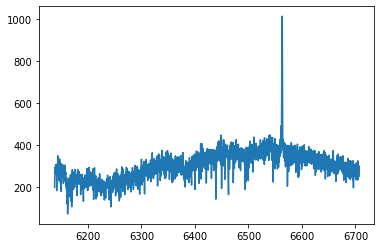

In [4]:
#open wavelength-calibrated unnormalized file:
file='Dr.-Yep-2024-summer-research/Day3/RED/wfun/wfun_CG22_1.fits'
hdu=fits.open(file)
w,f=hdu[0].data

#Take a look.
plt.figure()
plt.plot(w,f)

Regular norm:
spt options: K,M
favg: 303.7824238461562
[2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978]
narrow Ha
[6155, 6175, 6489, 6506, 6562.475510045142, 6563.4242482455875]
[6155, 6175, 6489, 6506, 6562.475510045142, 6563.4242482455875]
6 Even? True
8
flux std: 20.06427981302996
residuals: 777228.4635197063

M-star normM:
spt options: K,M
favg: 303.7824238461562
[2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978]
narrow Ha
[6152, 6180, 6215, 6250, 6350, 6466, 6477, 6524, 6562.475510045142, 6563.4242482455875, 6592, 6597, 6625, 6631, 6633, 6641, 6650, 6666, 6676, 6700]
[6152, 6180, 6215, 6250, 6350, 6466, 6477, 6524, 6562.475510045142, 6563.4242482455875, 6592, 6597, 6625, 6631, 6633, 6641, 6650, 6666, 6676, 6700]
20 Even? True
22
flux std: 20.88200267704838
residuals: 271938.1869857217


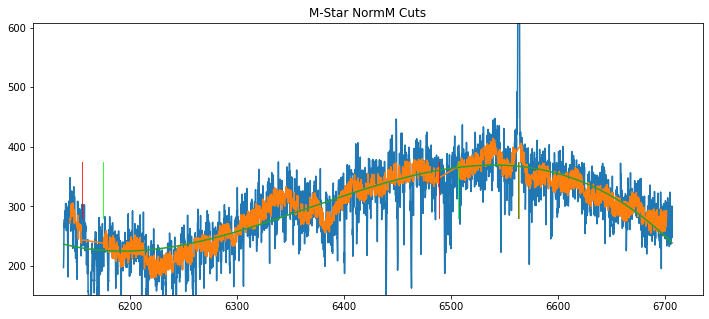

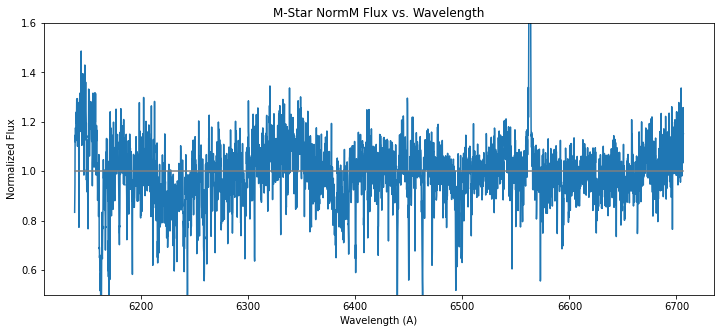

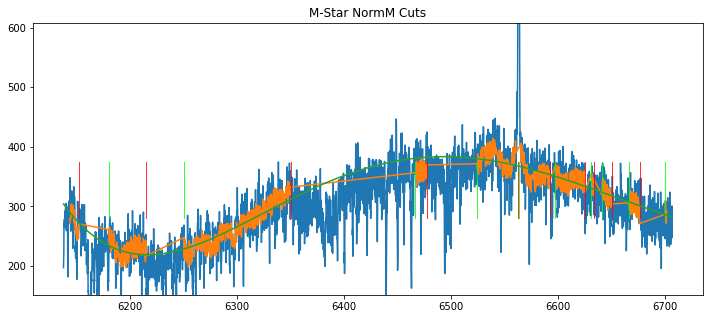

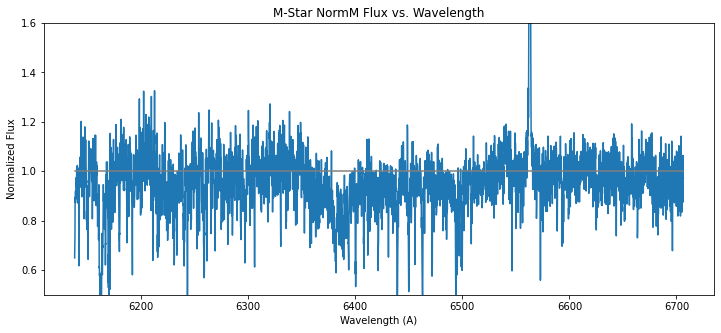

In [6]:
# Normalize the flux. Take a look at regular vs. M star version.
# Comment out the worse one and save the better one. There may be a way to automate this judgment.

print('Regular norm:')
fn=norm(w,f,'K')

print('\nM-star normM:')
fn=norm(w,f,'M')

In [7]:
#final check.
plotspec(w,fn)

/Users/Cougy/opt/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: PanTool,WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


Like it? save it as .fits, like you did for wfun, but now it's wfn? For normalized? Or just omit extra letters at this point...?